## Введение в глубокое обучение
### Занятие 7. Языковое моделирование и RNN

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev
##### Credits: Based on the notebook by [YSDA Practical RL course](https://github.com/yandexdataschool/Practical_RL/)

#### План занятия:
1. Введение в работу с последовательностями.
2. Принципы работы рекуррентных нейронных сетей.
3. Предобработка текстовых данных для задачи языкового моделирования.
4. Построение рекуррентной нейронной сети для задачи языкового моделирования.

### 1. Введение в работу с последовательностями.

__Go to slides__

### 2. Принципы работы рекуррентных нейронных сетей.

__Go to slides__

### 3. Предобработка текстовых данных для задачи языкового моделирования.
Расммотрим набор данных, который представляет собой список имен. Каждая последовательность – отдельное имя. В качестве токенов будем рассматривать отдельные символы.

In [1]:
import os
from random import sample

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import clear_output

Загрузим и предобработаем данные:

In [2]:
! wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/names -O names.txt

--2021-07-26 10:41:10--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55868 (55K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>]  54.56K  --.-KB/s    in 0.04s   

2021-07-26 10:41:10 (1.49 MB/s) - ‘names.txt’ saved [55868/55868]



In [3]:
start_token = " "

with open("names.txt") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + line for line in names]

Как видим, в датасете 7944 примера. Обратите внимание, каждая последовательность начинается с пробела.

In [4]:
print ('n_samples = ',len(names))
for x in names[::1000]:
    print (x)

n_samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


Рассмотрим распределение длин последовательностей:

max_length = 16


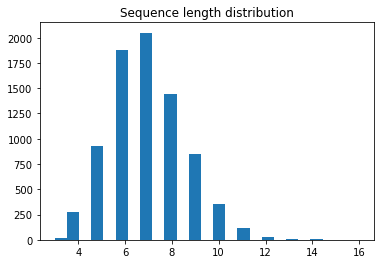

In [5]:
MAX_LENGTH = max(map(len, names))
print("max_length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)),bins=25);

#### Предобработка текста

Для начала построим "словарь" из всех уникальных токенов и пронумеруем их. Тогда мы можем кодировать входные данные как последовательность их индексов символов. Например, имя "Aboba" будет представлено как `[0, 1, 15, 1, 0]`.

In [6]:
tokens = set() # <list of all unique characters in the dataset>

for name in names:
    tokens.update(set(name))
tokens = list(tokens)

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  55


In [8]:
# <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {
    token: idx for idx, token in enumerate(tokens)
}

Теперь каждому соответствует уникальный индекс.

Наконец, реализуем функцию для преобразования список имен в матричное представление, которое в дальнейшем будет использоваться в качестве батча.
Т.к. тексты могут быть различной длины, дополним их до максимальной длины `max_len` или до длины самого длинного имени из выборки, если этот параметр не указан.

In [9]:
def to_matrix(names, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

Рассмотрим пример:

In [10]:
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[39 13 30 24 49 24  1  8 39]
 [39 36  8 31 38  3 39 39 39]
 [39 45 38 37  7  7 37  1 39]
 [39 36 37 31 40 24 44 44  1]]


#### 4. Построение рекуррентной нейронной сети для задачи языкового моделирования.
Наконец, перейдем непосредственно к построению рекуррентной нейронной сети. Сегодня мы реализуем ее с нуля. Готовый вариант доступен, например, в `torch.nn.RNN`.

Рекуррентную нейронную сеть можно рассматривать как последовательное применение плотного слоя к входу $x_t$ и предыдущему состоянию rnn $h_t$.
<img src="https://raw.githubusercontent.com/neychev/small_DL_repo/master/rnn.png" width=480>

Также нам понадобятся:
* Embedding-слой, который преобразует индекс токена $x_t$ в вектор. Принцип его действия аналогичен word2vec, который был рассмотрен ранее. Основное отличие: параметры обучаются непосредственно на данную задачу.
* Выходной слой, который предсказывает вероятность следующего токена.

In [21]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        # batch, seq leng, emb dim
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=-1) # YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) # YOUR CODE HERE
        
        h_next = torch.tanh(h_next) # YOUR CODE HERE
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next) # YOUR CODE
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [22]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

Теперь реализуем функцию для обработки каждого следующего элемента последовательности:

In [23]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(F.log_softmax(logits, -1))
        
    return torch.stack(logprobs, dim=1)

Наконец, проверим, что все работает:

In [24]:
batch_ix = to_matrix(names[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

#### Обучение языковой модели

Т.к. задача предсказания следующего токена – это задача классификации, в качестве функции потерь будет выступать уже знакомая нам кросс-энтропия.

В качестве "истинных значений" мы будем использовать `batch_ix[:, 1:]` - матрицу из индексов токенов, сдвинутых на один шаг вперед.

In [29]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

loss = criterion(
    predictions_logp.contiguous().view(-1, num_tokens),
    actual_next_tokens.contiguous().view(-1)
) 

loss.backward()

Финальная проверка:

In [31]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

#### Обучение модели

Сама процедура обучения практически не отличается от предыдущих. Единственное различие заключается в том, что в этот раз мы семплируем строки переменной длины, а затем приводим их к единой длине внутри одного батча.

In [32]:
char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

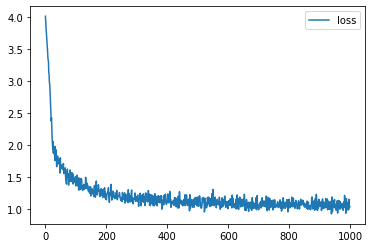

In [33]:
MAX_LENGTH = 16

for i in range(1000):
    opt.zero_grad()
    
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    
    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    ) 
    
    # train with backprop
    loss.backward()
    opt.step()
    
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

#### Генерация имен
После обучения языковой модели (а обученная нейросеть является языковой моделью) перейдем к генерации данных. 
Для этого воспользуемся функцией ниже:

In [34]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

Рассмотрим несколько случайных примеров:

In [75]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=1.))

 Tamiettie      
 Dualice        
 Eronf          
 Gredty         
 Gryannir       
 Pukra          
 Ritann         
 Sthoria        
 Hankoa         
 Komsie         


Также мы можем задать некоторую подстроку в для инициализации начального состояния нашей модели.

In [92]:
for _ in range(50):
    print(generate_sample(char_rnn, seed_phrase=' Adel', temperature=1.))

 Adela          
 Adellon        
 Adeled         
 Adelly         
 Adelie         
 Adelie         
 Adellina       
 Adellen        
 Adell          
 Adel           
 Adeld R        
 Adeldice       
 Adelrm         
 Adelma         
 Adelyy         
 Adelita        
 Adelvera       
 Adella         
 Adelan         
 Adelen         
 Adelit         
 Adella         
 Adele          
 Adelin         
 Adelene        
 Adeliar        
 Adel           
 Adela          
 Adelle         
 Adeld          
 Adellari       
 Adelias  e     
 Adelle         
 Adelio         
 Adelinit       
 Adelelly       
 Adelot         
 AdelZ          
 Adelien        
 Adellinnie     
 Adeleo         
 Adelea         
 Adelistas      
 Adelie         
 Adellrtt       
 Adella         
 Adela          
 Adeler         
 Adele          
 Adelen         


#### Использование готовых модулей

Только что мы реализовали RNN самостоятельно, что полезно, но требует некоторого времени. Конечно, на практике обычно используются уже готовые реализации.

В `torch` доступны два варианта классической RNN:
* `nn.RNNCell(emb_size, rnn_num_units)`, которая реализует один шаг RNN. Аналог того класса, что мы реализовали выше.
* `nn.RNN(emb_size, rnn_num_units)`, которая самостоятельно обрабатывает всю последовательность (аналог `nn.RNNCell` + `rnn_loop`).


Также существуют `nn.LSTMCell` и `nn.LSTM`, `nn.GRUCell` и `nn.GRU`.

Воспользуемся высокоуровневым API для получения аналогичных результатов:

In [93]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

In [94]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

logp_seq = model(batch_ix)

loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens), 
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

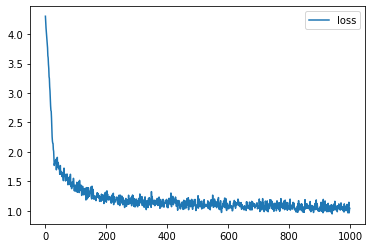

In [95]:
MAX_LENGTH = 16

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)
    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

#### Выводы:
* Рекуррентные нейронные сети позволяют работать с последовательностями переменной длины, обрабатывая по одному элементу за шаг.
* Задача языкового моделирования может рассматриваться как задача классификации, т.к. множество токенов конечно.
* Даже сложные модели могут быть реализованы с нуля. Но многие модули уже доступны в самом фреймворке.